使用Wasserstein对抗生成网络生成FashionMnist数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/FashionMNIST/"
NOISE_DIM = 100
IMAGE_SIZE = 28
IMAGE_CHANNEL = 1
BATCH_SIZE = 64
EPOCHS = 100
CLAMP_NUM = 0.01
LEARNING_RATE=5e-5

In [2]:
def weight_init(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(NOISE_DIM, 1024),
            torch.nn.BatchNorm1d(num_features=1024),
            torch.nn.ReLU(inplace=True)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 128 * 7 * 7),
            torch.nn.BatchNorm1d(num_features=128*7*7),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, IMAGE_CHANNEL, 4, 2, 1),
            torch.nn.Tanh()
        )

        weight_init(self)

    def forward(self, x):
        output = self.fc1(x)
        output = self.fc2(output)
        output = output.view(-1, 128, 7, 7)
        output = self.deconv1(output)
        output = self.deconv2(output)

        return output

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64, 4, 2, 1),
            torch.nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 4, 2, 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.LeakyReLU(negative_slope=0.2)
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128*7*7, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(negative_slope=0.2)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 1)
        )

        weight_init(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = output.view(-1, 128*7*7)
        output = self.fc1(output)
        output = self.fc2(output)
        output = output.mean(0).view(1)

        return output

# 3.导入数据

In [4]:
NetD = Discriminator()
NetG = Generator()

optimizerD = torch.optim.RMSprop(NetD.parameters(), lr=LEARNING_RATE)
optimizerG = torch.optim.RMSprop(NetG.parameters(), lr=LEARNING_RATE)

trans = tv.transforms.Compose([tv.transforms.ToTensor(),
                               tv.transforms.Normalize([0.5], [0.5])
                               ])
train_dataset = tv.datasets.FashionMNIST(root=DATA_PATH,
                               train=True,
                               transform=trans,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

one=torch.FloatTensor([1])
mone = -1 * one
one_var  = torch.autograd.Variable(one)
mone_var = torch.autograd.Variable(mone)

fix_noise     = torch.FloatTensor(100, NOISE_DIM).normal_(0,1)
fix_noise_var = torch.autograd.Variable(fix_noise)

if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    one_var = one_var.cuda()
    mone_var = mone_var.cuda()
    fix_noise_var = fix_noise_var.cuda()

# 4.训练

In [5]:
showbar = bar.ProgressBar(EPOCHS, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCHS + 1):
    for index, (image, label) in enumerate(train_loader):
        real  = image
        real_var = torch.autograd.Variable(real)
        noise = torch.randn(real_var.size(0),NOISE_DIM)
        noise_var = torch.autograd.Variable(noise)

        if torch.cuda.is_available():
            real_var = real_var.cuda()
            noise_var = noise_var.cuda()

        for parm in NetD.parameters():
            parm.data.clamp_(-CLAMP_NUM, CLAMP_NUM)

        NetD.zero_grad()
        D_real=NetD(real_var)
        D_real.backward(one_var)

        fake_pic=NetG(noise_var).detach()
        D_fake=NetD(fake_pic)
        D_fake.backward(mone_var)
        optimizerD.step()

        G_ = D_fake
        if (index+1)%5 ==0:
            NetG.zero_grad()
            noise.data.normal_(0,1)
            fake_pic=NetG(noise_var)
            G_=NetD(fake_pic)
            G_.backward(one_var)
            optimizerG.step()
            if index%100==0:
                pass
        showbar.show(epoch, D_fake.item(), G_.item())

Epoch:1 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.006;G Loss:0.006,total=0:00:260
Epoch:2 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.006;G Loss:0.006,total=0:00:250
Epoch:3 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.006;G Loss:0.006,total=0:00:260
Epoch:4 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.006;G Loss:0.006,total=0:00:250
Epoch:5 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.007;G Loss:0.007,total=0:00:25032:33
Epoch:6 / 100 [********************************************************************************************************] 938 / 938

Epoch:47 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.004;G Loss:0.004,total=0:00:250119:1527
Epoch:48 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.004;G Loss:0.004,total=0:00:250410:396
Epoch:49 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.004;G Loss:0.004,total=0:00:250341:1136
Epoch:50 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.004;G Loss:0.004,total=0:00:250401:5395
Epoch:51 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.004;G Loss:0.004,total=0:00:250562:296
Epoch:52 / 100 [****************************************************************************

Epoch:92 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.001;G Loss:0.001,total=0:00:250281:3415
Epoch:93 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.005;G Loss:0.005,total=0:00:250036:12118
Epoch:94 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.004;G Loss:0.004,total=0:00:260731:52446
Epoch:95 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.004;G Loss:0.004,total=0:00:260057:45026
Epoch:96 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.002;G Loss:0.002,total=0:00:260703:4458
Epoch:97 / 100 [***********************************************************************

# 5.生成数据

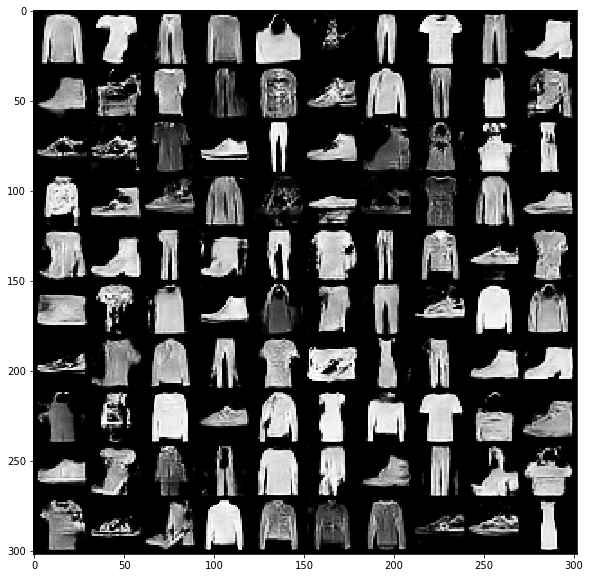

In [6]:
fake_u=NetG(fix_noise_var)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))